# 作業 1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個 CNN 模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**


>**作業說明**

**第一步驟**: 左上角 檔案 -> 在雲端硬碟建立副本。

**第二步驟**: 右上角 共用 -> 取得連結 -> 任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段 -> 更變執行類型 -> GPU。可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個 colab 的程式來完成訓練 CNN 模型。**只要跑得出來 Testing Accuracy、Loss; 1~7 個作業項目即可**，不必一定要照著 todo 提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的 label 不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label 隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看 test data
2. 模型請手刻、手疊，**不要用 Transfer Learning** 來引入 ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**


### 資料集下載

- 資料集說明 :
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊 colab 左側**檔案**來查看

- 下載連結：
  - train: https://drive.google.com/file/d/1K3FRVeabwV7TxboRsrkFcT34tPV9DWqr/view?usp=sharing
  - test: https://drive.google.com/file/d/1GCzWxFrIbb4d1JSXSrt3kRb6uERVqXpx/view?usp=sharing


In [ ]:
import random
import os

# 大家盡量先把資料保存在本地端，然後要訓練時用本地端上傳做訓練
# 以節省學術網路資源，避免 IP 被封鎖

if not os.path.isfile("./train.zip"):
    !wget -O train.zip "http://140.115.83.111/files/art/train.zip"
    !wget -O test.zip "http://140.115.83.111/files/art/test.zip"
    !unzip train.zip
    !unzip test.zip
else:
    !echo "檔案已存在"

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Joan_Miro_27.jpg  
  inflating: train_resized/Joan_Miro_28.jpg  
  inflating: train_resized/Joan_Miro_29.jpg  
  inflating: train_resized/Joan_Miro_3.jpg  
  inflating: train_resized/Joan_Miro_30.jpg  
  inflating: train_resized/Joan_Miro_31.jpg  
  inflating: train_resized/Joan_Miro_32.jpg  
  inflating: train_resized/Joan_Miro_33.jpg  
  inflating: train_resized/Joan_Miro_34.jpg  
  inflating: train_resized/Joan_Miro_35.jpg  
  inflating: train_resized/Joan_Miro_36.jpg  
  inflating: train_resized/Joan_Miro_37.jpg  
  inflating: train_resized/Joan_Miro_39.jpg  
  inflating: train_resized/Joan_Miro_4.jpg  
  inflating: train_resized/Joan_Miro_40.jpg  
  inflating: train_resized/Joan_Miro_42.jpg  
  inflating: train_resized/Joan_Miro_43.jpg  
  inflating: train_resized/Joan_Miro_44.jpg  
  inflating: train_resized/Joan_Miro_45.jpg  
  inflating: train_resized/Joan_Miro_46.jpg  
  inflating: train_resized/Joan_Miro_47.jpg  
  inflating: tr

## 1. 讀入封包

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import seaborn as sns
from pathlib import Path
import re
from sklearn.utils.class_weight import compute_class_weight

## 2. 取得資料集

- **我們來檢視一下 artist.csv**，重要內容包含:
  - 畫家名稱 (name)
  - 風格 (genre)
  - 資料集內畫作數量 (paintings)

總共有 50 位畫家，意謂著有 50 個 class 要去辨識。

In [ ]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ", num_classes)
artists.head()

Number of artists :  50


id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: ?а?и?...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod m?n?]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [??ne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

* 只取出名字與畫的數量，把名字用下底線連起來

In [ ]:
artists = artists.loc[:, ["name", "paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))
artists.head()

name  paintings
0   Amedeo_Modigliani        193
1  Vasiliy_Kandinskiy         88
2        Diego_Rivera         70
3        Claude_Monet         73
4       Rene_Magritte        194

* **計算各個畫家畫作數量**
* 每個 class 資料的不平衡容易影響模型的訓練，學生可以嘗試解決這個問題。(提示: keras 的 class_weight)

可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。
最多畫作為 :  877  最少畫作為 :  24


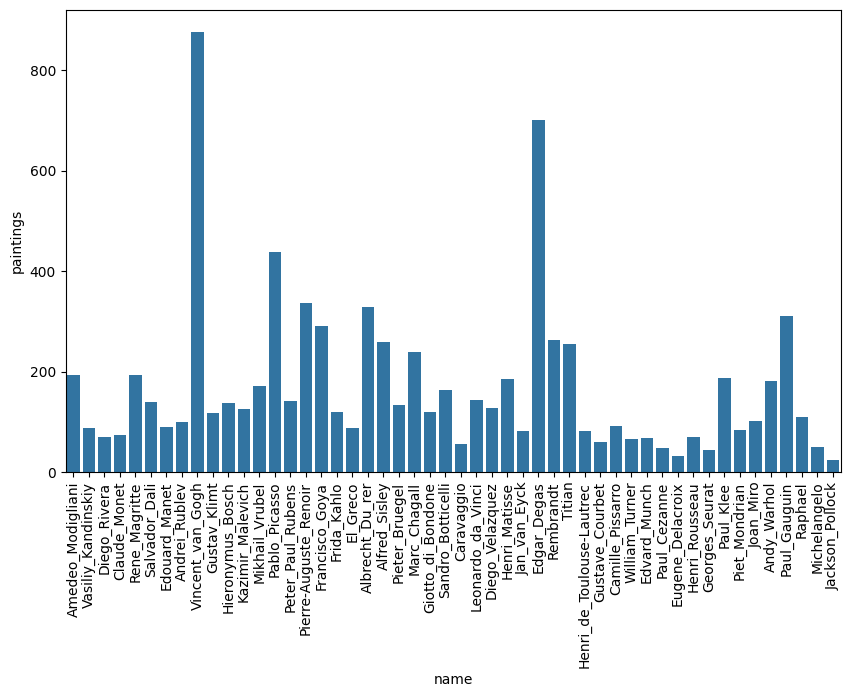

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=artists.name, y=artists.paintings)
for item in barplot.get_xticklabels():
    item.set_rotation(90)

print("可以看到每個畫家之間的畫作數量很不平均，這會影響到模型的訓練。")
print("最多畫作為 : ", artists.paintings.max(), " 最少畫作為 : ", artists.paintings.min())

In [ ]:
def get_target_dict(csv_path):
    target_dict = {}
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    df = df.loc[:, ["name", "paintings"]]
    df["name"] = df["name"].str.split(" ").apply(lambda parts: "_".join(parts))
    for index, artist_info in df.iterrows():
        name = artist_info["name"]
        target_dict.setdefault(index, name)
    return target_dict

target_dict = get_target_dict("/content/artists.csv")

print(target_dict)

{0: 'Amedeo_Modigliani', 1: 'Vasiliy_Kandinskiy', 2: 'Diego_Rivera', 3: 'Claude_Monet', 4: 'Rene_Magritte', 5: 'Salvador_Dali', 6: 'Edouard_Manet', 7: 'Andrei_Rublev', 8: 'Vincent_van_Gogh', 9: 'Gustav_Klimt', 10: 'Hieronymus_Bosch', 11: 'Kazimir_Malevich', 12: 'Mikhail_Vrubel', 13: 'Pablo_Picasso', 14: 'Peter_Paul_Rubens', 15: 'Pierre-Auguste_Renoir', 16: 'Francisco_Goya', 17: 'Frida_Kahlo', 18: 'El_Greco', 19: 'Albrecht_Du_rer', 20: 'Alfred_Sisley', 21: 'Pieter_Bruegel', 22: 'Marc_Chagall', 23: 'Giotto_di_Bondone', 24: 'Sandro_Botticelli', 25: 'Caravaggio', 26: 'Leonardo_da_Vinci', 27: 'Diego_Velazquez', 28: 'Henri_Matisse', 29: 'Jan_van_Eyck', 30: 'Edgar_Degas', 31: 'Rembrandt', 32: 'Titian', 33: 'Henri_de_Toulouse-Lautrec', 34: 'Gustave_Courbet', 35: 'Camille_Pissarro', 36: 'William_Turner', 37: 'Edvard_Munch', 38: 'Paul_Cezanne', 39: 'Eugene_Delacroix', 40: 'Henri_Rousseau', 41: 'Georges_Seurat', 42: 'Paul_Klee', 43: 'Piet_Mondrian', 44: 'Joan_Miro', 45: 'Andy_Warhol', 46: 'Paul_G

In [ ]:
def get_class_weight(class_amount):
    class_weight ={}
    y = []
    classes = list(range(len(class_amount)))
    for key, value in class_amount.items():
        weight = np.ones([int(value)])* key
        y.extend(weight)
    weights = compute_class_weight(class_weight = 'balanced', classes = classes, y=y)
    for index, weight in enumerate(weights):
        class_weight.setdefault(index, weight)
    return class_weight

* 隨機讀取畫作來看看

training 畫作總共畫作有 :  7520


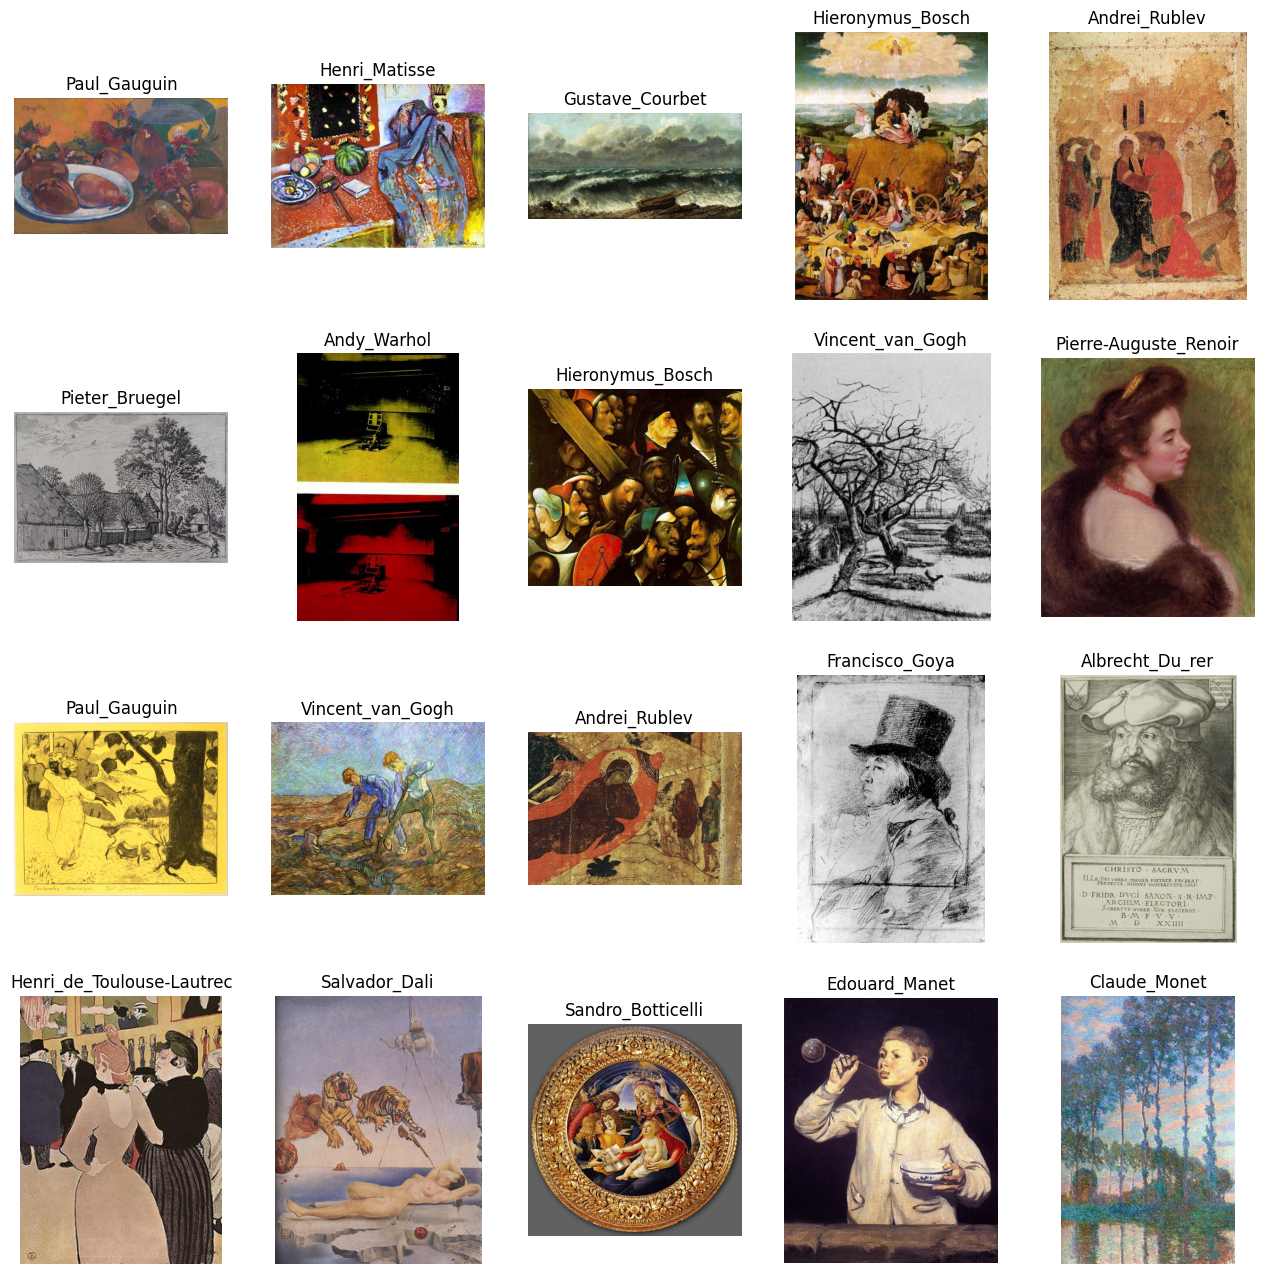

In [ ]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
random_list = random.sample(range(0, total_len), 20)
print("training 畫作總共畫作有 : ", total_len)

show_imgs = [img_list[rand] for rand in random_list]

plt.figure(figsize=(16, 16))
for index, imgName in enumerate(show_imgs):
    img_path = train_dir + imgName
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(4, 5, index + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理

**有幾個重要的點需要處理**
1. 我們現在只有各個畫的路徑。Ex: /content/train_resized/Claude_Monet_22.jpg 。要取出 label : Claude_Monet
2. label (作者名稱)是英文，我們要先把英文映射成數字。EX: Van_Gogh --> 0 ; Edvard_Munch --> 1
3. label 數字還要轉成 50 depth 的 one_hot
4. 現在有畫的路徑了，要讀取圖片
5. 每張圖片的大小不一樣，要統一大小才能輸入模型
6. 把每張圖片正規化，映射到 [0,1] 之間
7. 路徑是按照作者名稱排列的，太整齊了，把資料集打散(shuffle)。
8. 如果有需要，拆分成訓練用資料(training_data)、驗證用(validation_data)
9. **重要!** 確定好你資料 input output 的維度，才能開始建立模型。EX: input:(256,256,3); output:(50,)

**助教推薦一個好用的工具** from_tensor_slices [參考](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

* from_tensor_slices 可以輕鬆的讀取想要的資料，把圖片路徑傳入 tensor 後用 map 將路徑轉成圖片檔案。

* **以下程式 todo 只是提供程式思路，你完全可以不理他，反正 test 結果能出來就好。**

In [ ]:
class Preprocessor:
    def __init__(self, dir_path, target_dict, resized_ratio=(100,100)):
        self.dir_path = Path(dir_path)
        self.target_dict = target_dict
        self.resized_width = resized_ratio[0]
        self.resized_height = resized_ratio[1]

    def collect_img_target(self):
        pattern = re.compile(r"^[A-Za-z_-]{,30}")
        one_hot = np.zeros((len(self.target_dict)))
        img_paths = []
        labels = []
        for path in self.dir_path.glob("*.jpg"):
            img_paths.append(f"{path}")
            match_result = pattern.search(path.name)
            artist_name = match_result.group()[:-1] if match_result != None else None
            name2index_dict = {name: index for index, name in self.target_dict.items()}
            label_index = name2index_dict[artist_name]
            label = [ 1 if i == label_index else 0 for i, _ in enumerate(one_hot) ]
            labels.append(label)
        return img_paths, labels

    def get_image(self, path):
        # read image from path
        file = tf.io.read_file(path)
        img = tf.io.decode_jpeg(file, channels=3)
        img = tf.cast(img, tf.float32)
        resize_image = tf.image.resize(img, [self.resized_width, self.resized_height])
        img = resize_image / 255
        return img

    def make_dataset(self):
        img_paths, labels = self.collect_img_target()
        # SHUFFLE_BUFFER = len(img_paths)
        paths_ds = tf.data.Dataset.from_tensor_slices(img_paths)
        label = tf.data.Dataset.from_tensor_slices(labels)
        # 將路徑 tensor 映射成圖片 tensor
        img_data = paths_ds.map(self.get_image)
        # 合併圖片與 label 資料集
        full_ds = tf.data.Dataset.zip((img_data, label))
        #  打散
        SHUFFLE_BUFFER = len(img_data)
        full_ds = full_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)
        return full_ds

    def get_class_amount(self):
        class_amount = {}
        _, labels = self.collect_img_target()
        count = np.zeros(len(self.target_dict))
        for label in labels:
            count += label
        for index, amount in enumerate(count):
            class_amount.setdefault(index, amount)
        return class_amount

train size :  6392  val size :  1128


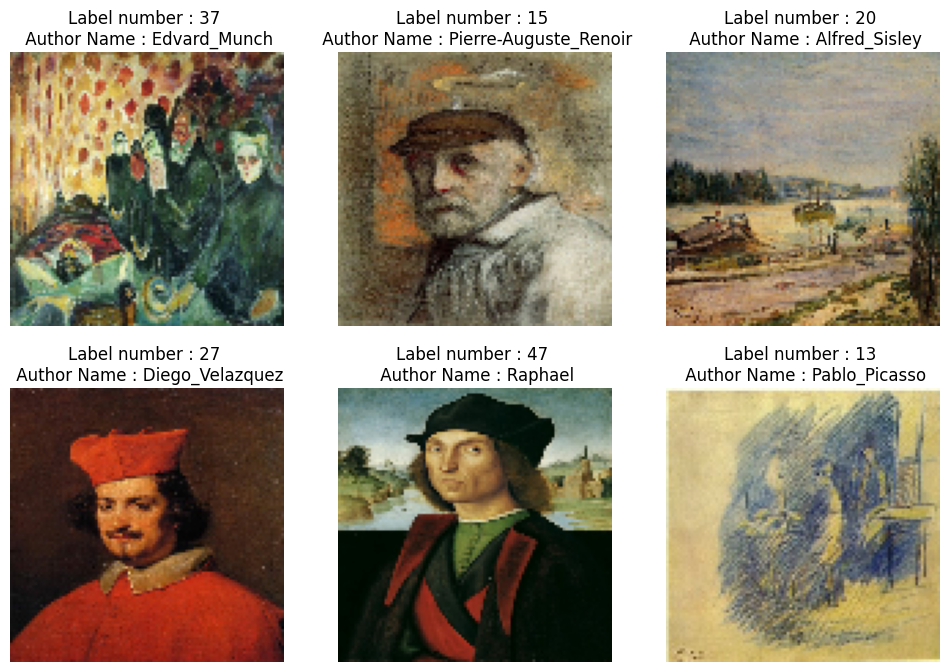

In [ ]:
RESIZED_WIDTH = 100
RESIZED_HEIGHT = 100


training_processor = Preprocessor("/content/train_resized", \
                                target_dict, \
                  (RESIZED_WIDTH, RESIZED_HEIGHT))
training_ds = training_processor.make_dataset()
class_amount = training_processor.get_class_amount()
class_weight = get_class_weight(class_amount)

def split_data(data, ratio):
    data_len = len(data)
    train_len = int(ratio * data_len)
    val_len = data_len - train_len
    train_ds = training_ds.take(train_len)
    val_ds = training_ds.skip(train_len)
    return train_ds, val_ds

train_ds, val_ds = split_data(training_ds, 0.85)

print("train size : ", len(train_ds), " val size : ", len(val_ds))

plt.figure(figsize=(12, 8))
for index, (img, target_label) in enumerate(val_ds.take(6)):
    l = np.argmax(target_label.numpy())
    plt.subplot(2, 3, index + 1)
    plt.imshow(img)
    plt.title(f"Label number : {l} \n Author Name : {target_dict[l]}")
    plt.axis("off")

BATCH_SIZE = 128

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x, y = trainiter.next()
print("training image batch shape : ", x.shape)
print("training label batch shape : ", y.shape)

training image batch shape :  (128, 100, 100, 3)
training label batch shape :  (128, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做 fine-tuning，**請自己手動建**。

In [ ]:
input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(4, 4)),
        layers.Flatten(),
        layers.Dense(1024),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.05),
        layers.Dense(50, activation="softmax"),
    ]
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 98, 98, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 47, 47, 64)        2

## 5. 制定訓練計畫

把前處理完的資料輸入進去

In [ ]:
model.compile(loss="categorical_crossentropy", \
              optimizer="adam", \
              metrics=["accuracy"])

In [ ]:
EPOCHS = 20
history = model.fit(train_ds, \
           epochs=EPOCHS, \
           validation_data=val_ds, \
           class_weight=class_weight)

Epoch 1/20
50/50 [==============================] - 49s 490ms/step - loss: 3.3006 - accuracy: 0.1841 - val_loss: 4.3710 - val_accuracy: 0.0124
Epoch 2/20
50/50 [==============================] - 38s 430ms/step - loss: 1.8160 - accuracy: 0.4318 - val_loss: 5.5609 - val_accuracy: 0.0124
Epoch 3/20
50/50 [==============================] - 35s 384ms/step - loss: 0.8684 - accuracy: 0.6735 - val_loss: 6.1457 - val_accuracy: 0.0168
Epoch 4/20
50/50 [==============================] - 35s 397ms/step - loss: 0.3994 - accuracy: 0.8456 - val_loss: 6.0845 - val_accuracy: 0.0399
Epoch 5/20
50/50 [==============================] - 36s 405ms/step - loss: 0.1951 - accuracy: 0.9273 - val_loss: 6.0926 - val_accuracy: 0.0461
Epoch 6/20
50/50 [==============================] - 40s 470ms/step - loss: 0.0921 - accuracy: 0.9671 - val_loss: 6.8612 - val_accuracy: 0.0301
Epoch 7/20
50/50 [==============================] - 35s 385ms/step - loss: 0.0506 - accuracy: 0.9850 - val_loss: 6.8011 - val_accuracy: 0.0417

## 6. 評估模型

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


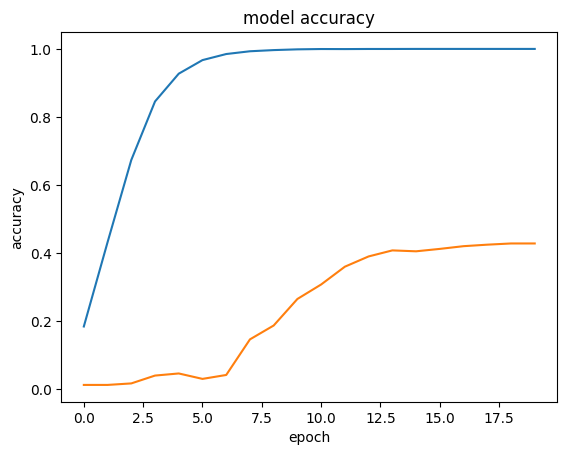

In [ ]:
print(history.history.keys())

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

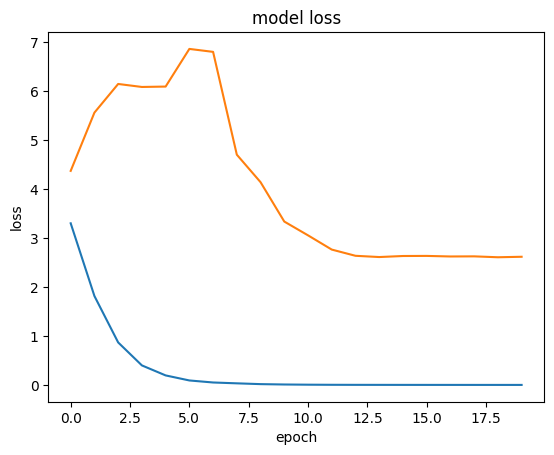

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.show()

In [ ]:
# 讀入測試資料並評估模型
BATCH_SIZE = 128
test_processor = Preprocessor("/content/test_resized", target_dict, (RESIZED_WIDTH, RESIZED_HEIGHT))
test_ds = test_processor.make_dataset()

test_ds = test_ds.batch(BATCH_SIZE)
score = model.evaluate(test_ds)


print("Test loss:", score[0])
print("Test accuracy:", score[1])

7/7 [==============================] - 2s 65ms/step - loss: 2.6131 - accuracy: 0.4084
Test loss: 2.6130847930908203
Test accuracy: 0.40838322043418884


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入 Model 做預測

1/1 [==============================] - 0s 291ms/step


Text(0.5, 1.0, 'Author Name : Albrecht_Du_rer')

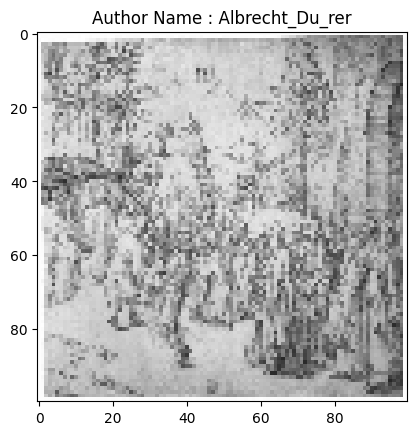

In [ ]:
def img_process(img_path):
    file = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(file, channels=3)
    img = tf.cast(img, tf.float32)
    resize_img = tf.image.resize(img, [RESIZED_WIDTH, RESIZED_HEIGHT])
    img = resize_img / 255
    return img
def predict(img):
    expand_img = tf.expand_dims(img, axis=0)
    pred = model.predict(expand_img)
    index = np.argmax(pred)
    result = target_dict[index]
    return result
img = img_process("/content/test_resized/Albrecht_Du_rer_46.jpg")
result = predict(img)
plt.imshow(img)
plt.title(f"Author Name : {result}")

* 期望結果
![](https://i.imgur.com/ZEtd7yf.png)

* 自己上傳圖片來試試看模型的效果

In [ ]:
from google.colab import files


def upload_img():
    uploaded = files.upload()
    img_name = list(uploaded.keys())[0]
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (RESIZED_WIDTH, RESIZED_HEIGHT))
    img = img / 255.0
    return img

def eval():
    img = upload_img()
    plt.title("predict author : {}".format(predict(img)))
    plt.axis("off")
    plt.show()

Saving PIKACHU.png to PIKACHU.png
1/1 [==============================] - 0s 31ms/step


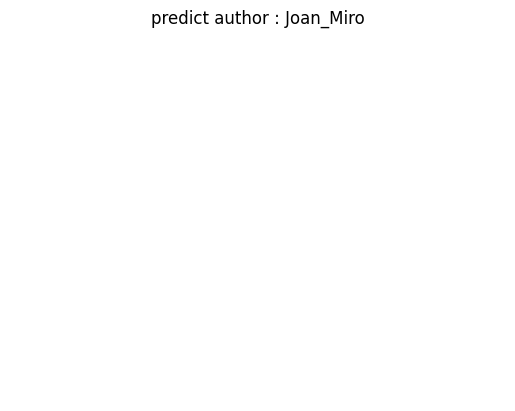

In [ ]:
# 自己上傳一張圖片來試試看
# Demo 圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()